In [11]:
import numpy as np
import dolfin
import logging
logging.getLogger('FFC').setLevel(logging.WARNING)
import matplotlib
import green_approx
%load_ext line_profiler
import sys

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler



Some interesting things to look into...
* Having more points in the x direction *should* reduce our uncertainty in the solution of the Green's function, one would hope.
* The question here is - where is the uncertainty coming from? 
* Look at the link to classical Monte Carlo & project that into function space. In classical Monte Carlo the uncertainty comes from the fact that we are unable to evalute the entire integral, but we _can_ evaluate the integrand. The integral is effectively an average across the entire domain of the function, and so when we know the function value only at a small subset of points there is a degree of error in the estimate of the integral. As the number of points increases that error diminishes to nothing.
* The analogue in function space is more difficult because we are infinite-dimensional. Gaussianity helps us (somehow) here, I think.
* So the question here is where is my error coming from. The analogue of the input domain here is the function space. So in theory if I could evalute every function in the function space then I would end up with... a dirac? Is that right though? The variance scales to zero as the number of samples scales to infinity, so in theory yes, although we are going to a _countable_ infinity right? So this is reliant on compactness somehow.

In [2]:
# for ipython notebook
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.tri as tri

def mesh2triang(mesh):
    xy = mesh.coordinates()
    return tri.Triangulation(xy[:, 0], xy[:, 1], mesh.cells())

def plot(obj):
    plt.gca().set_aspect('equal')
    if isinstance(obj, dolfin.Function):
        mesh = obj.function_space().mesh()
        if (mesh.geometry().dim() != 2):
            raise(AttributeError)
        if obj.vector().size() == mesh.num_cells():
            C = obj.vector().array()
            plt.tripcolor(mesh2triang(mesh), C)
        else:
            C = obj.compute_vertex_values(mesh)
            plt.tripcolor(mesh2triang(mesh), C, shading='gouraud')
    elif isinstance(obj, dolfin.Mesh):
        if (obj.geometry().dim() != 2):
            raise(AttributeError)
        plt.triplot(mesh2triang(obj), color='k')


In [3]:

# Create mesh and define function space
mesh = dolfin.UnitIntervalMesh(100)
V = dolfin.FunctionSpace(mesh, 'Lagrange', 1)
u0 = dolfin.Constant(0)
def u0_boundary(x, on_boundary):
    return on_boundary
bc = dolfin.DirichletBC(V, u0, u0_boundary)
L_weak = lambda u, v: -dolfin.inner(dolfin.nabla_grad(u), dolfin.nabla_grad(v))

approx = green_approx.GreenFunctionApproximator(V, L_weak, bc, 20.)

n = V.dim()                                                                      
d = mesh.geometry().dim()   
dof_coordinates = V.dofmap().tabulate_all_coordinates(mesh)                      
dof_coordinates.resize((n, d))

In [4]:
# Mesh = 100, S=10000 : 53.4 s
# Mesh = 1000, S = 10000 : 2min 15s

In [5]:
x_prime = 0.3
%lprun -f approx._propose fns, acceptances = approx.approximate(x_prime, 10000)
#fns, acceptances = sample_green(x_prime, L_weak, 10000)

In [6]:
def plot_mcmc_results(fns, plot_thin=10, burn=0):
    mean = np.zeros_like(fns[0].vector().array())
    for i in range(burn, len(fns)):
        arr = fns[i].vector().array()
        mean += arr
    #    if i % plot_thin == 0:
    #        plt.plot(dof_coordinates, arr)
    std = np.zeros_like(mean)
    for i in range(len(mean)):
        arr = np.array([f.vector().array()[i] for f in fns[burn:]])
        std[i] = np.std(arr)
    mean = mean * 1. / (len(fns) - burn)
    plt.fill_between(dof_coordinates.ravel(), mean-std, mean+std, linewidth=0, color='lightblue', alpha=0.5)
    plt.plot(dof_coordinates, mean, linewidth=1, label='Mean', c='blue')

Acceptance ratio: 0.3783


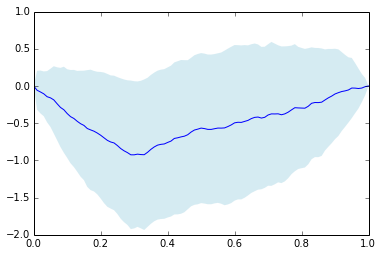

In [7]:
print 'Acceptance ratio: {}'.format(np.mean(acceptances))
plot_mcmc_results(fns)

## Some Issues
* The sample represents evaluation of the Green's function at a particular point - the point at which the second argument is to be evaluated. This means that each time we want to center a Green's function at a different point we need to repeat the MCMC!!!
    * On the other hand - let's think about the integral we are actually doing here. We are _integrating_ over one argument of the Green's function, so we can hide that massive simulation inside the integral. Furthermore (because symmetry) there should be no problem in using the same sample for computing _both_ integrals, so that removes some of the effort.
    * The integral in question is going to be a *weighted average* of this evaluated at multiple points. $k(x,x^\prime) = \int G(x,z) \Lambda(x^\prime, z) dz$. Change $x$ and what happens to the integral?
    * The bad thing here is that if I want to evaluate this at a *new* x then I am going to have a pretty nasty problem. No - actually this is what I'm talking about above. Fixing one argument of the Green's function (as I do when I integrate), the simulation gives me a function which I can evaluate at any other point. In fact, since my FEM approximation is a weighted sum of basis functions, I can probably do something even simpler... right?
* Can we actually interpret this as a sample from feasible Green's functions?

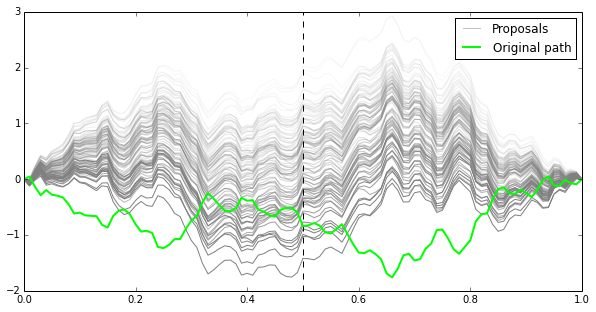

In [8]:
evalat=0.5
plt.figure(figsize=(10,5))
for i in xrange(100):
    new = approx._propose(fns[-1])
    alpha = np.exp(min(0, fns[-1](evalat) - new(evalat)))
    plt.plot(dof_coordinates, new.vector().array(), c='gray', alpha=alpha)
plt.axvline(evalat, c='black', linestyle='--')

plt.plot(dof_coordinates, approx._propose(fns[-1]).vector().array(), c='gray', alpha=0.5, label='Proposals')
plt.plot(dof_coordinates, fns[-1].vector().array(), c='lime', linewidth=2, label='Original path')
plt.legend()

Okay, so Tim's advice: just go ahead with it and see what happens. In which case, I have to write an algorithm for determining my posterior.

Inputs: we need a $\Lambda$ and (ofc) the PDE itself. Algorithm sketch:

**Calculate Ak**
There is a pretty large margin of error here, so I think my function Ak will actually be a *distribution* over functions. The distribution needs to incorporate:

* Numerical error from the Green's function approximation
* Numerical error from the numerical integration.

The posterior distribution over the former is available. The posterior distribution over the *latter* is complicated, because I will also have numerical error here.

So $u|Ak$ is a Gaussian. $k|G$ is a Gaussian. $G$ is a (highly) non-Gaussian. Basically I want to marginalise the error from both $k|G$ and $G$ itself.

To start with - let's _pretend_ we can calculate that Dirac measure $k|G$. So in other words, let's just chuck a bunch of $z$ at the problem and hope it goes away.

In [9]:
def Ak(Gs, zs, Lambda):
    garr = np.array([G.vector().array() for G in Gs]).T
    return lambda x: (Lambda(x, zs) * garr).mean(axis=0)

In [23]:
def u(Gs, zs, f):
    garr = np.array([G.vector().array() for G in Gs]).T
    return (f(zs) * garr).mean(axis=0)

In [ ]:
results = {}

In [38]:
x_primes = np.linspace(0,1,41)
for x_prime in x_primes:
    if x_prime in results: continue
    print 'Generating for {}'.format(x_prime),
    sys.stdout.flush()
    fns, acceptances = approx.approximate(x_prime, int(10000))
    results[x_prime] = fns
    print '... done'

Generating for 0.025 ... done
Generating for 0.075 ... done
Generating for 0.125 ... done
Generating for 0.175 ... done
Generating for 0.225 ... done
Generating for 0.275 ... done
Generating for 0.325 ... done
Generating for 0.375 ... done
Generating for 0.425 ... done
Generating for 0.475 ... done
Generating for 0.525 ... done
Generating for 0.575 ... done
Generating for 0.625 ... done
Generating for 0.675 ... done
Generating for 0.725 ... done
Generating for 0.775 ... done
Generating for 0.825 ... done
Generating for 0.875 ... done
Generating for 0.925 ... done
Generating for 0.975 ... done


In [39]:
import pickle

In [42]:
with open('laplacian_mcmc_41pts_10000samples_100grid.pkl', 'wb') as f:
    pickle.dump({k: [v1.vector().array() for v1 in v] for k, v in results.iteritems()}, f)

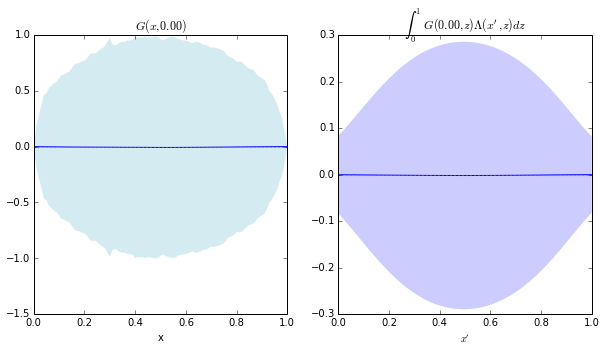

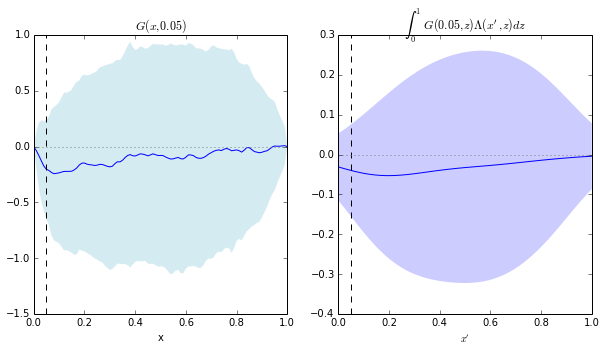

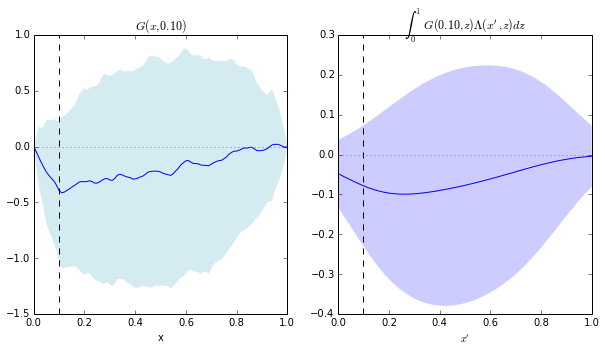

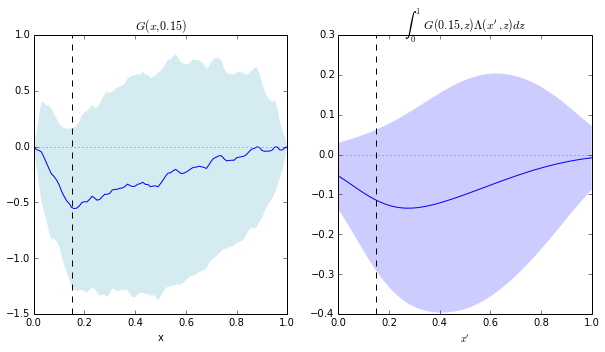

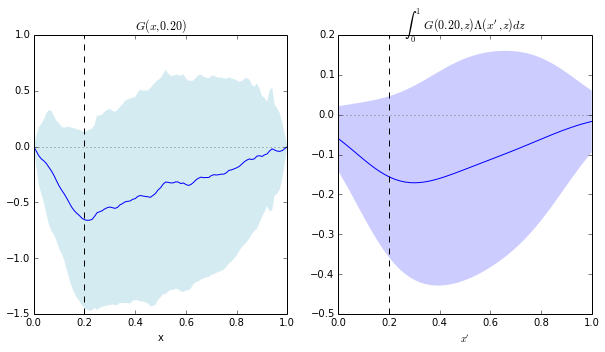

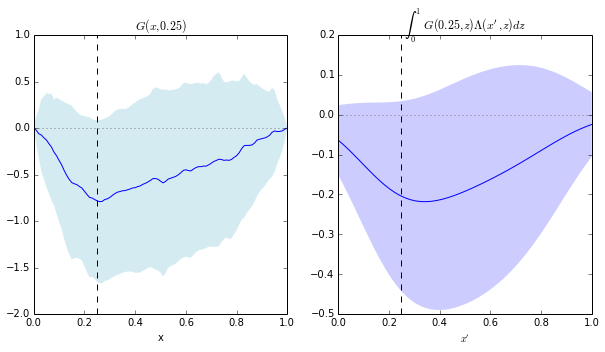

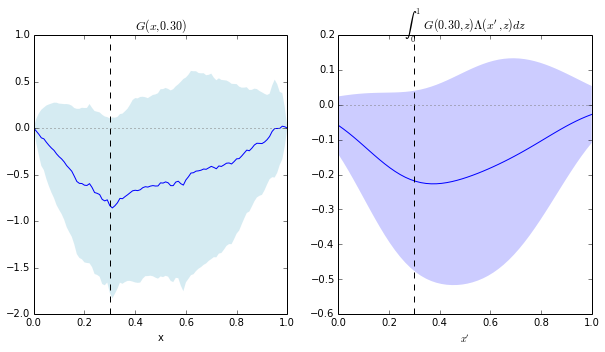

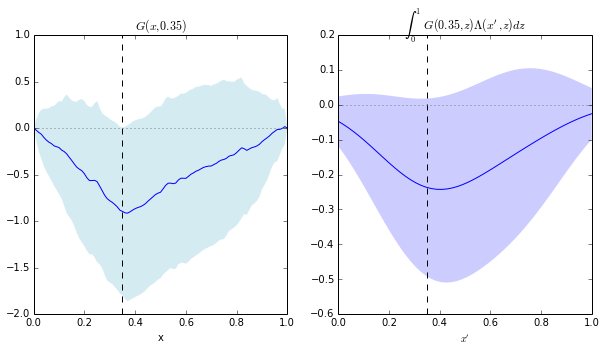

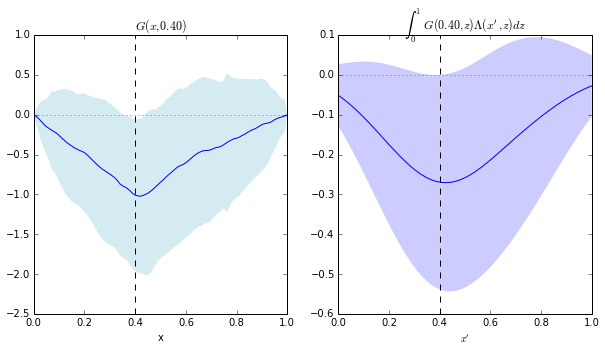

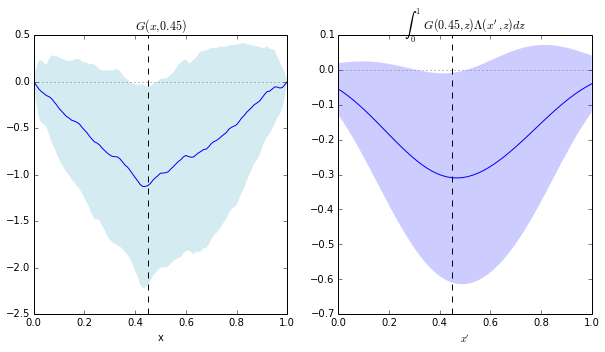

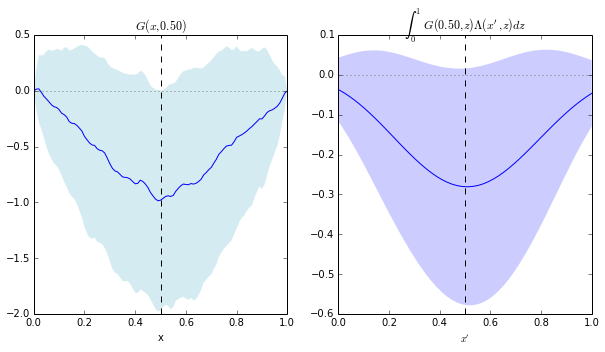

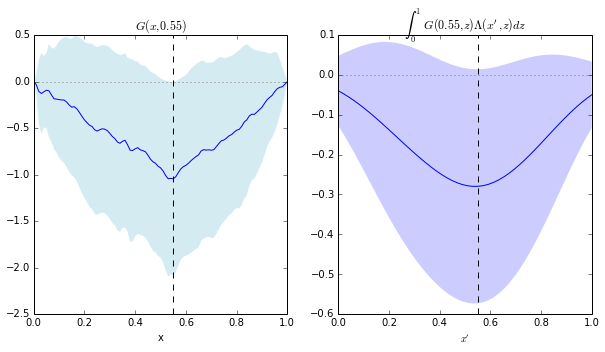

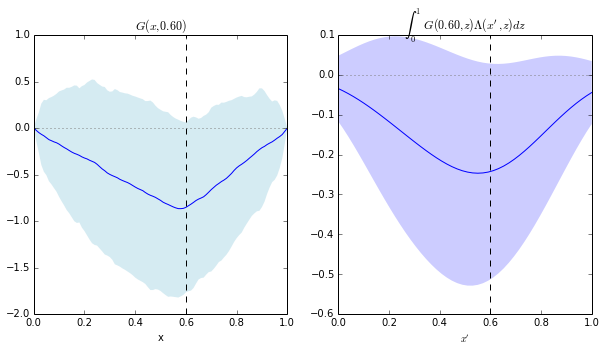

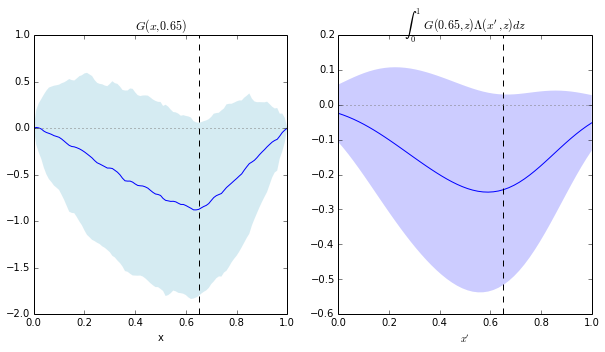

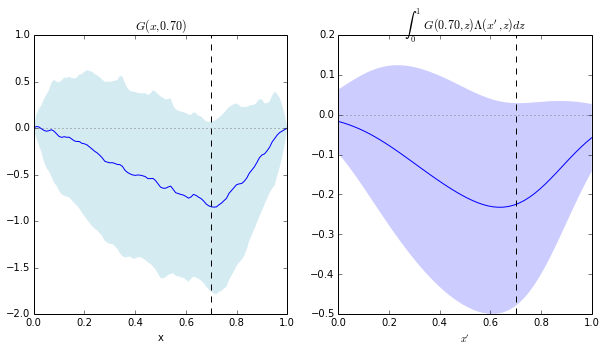

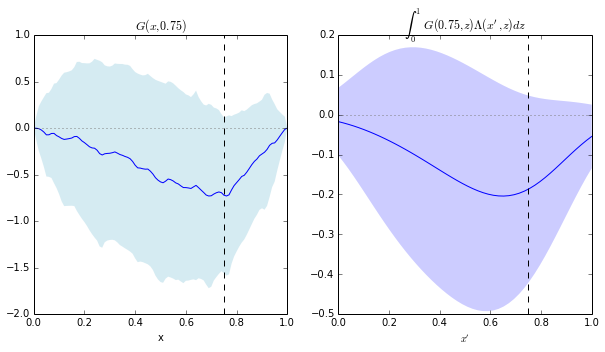

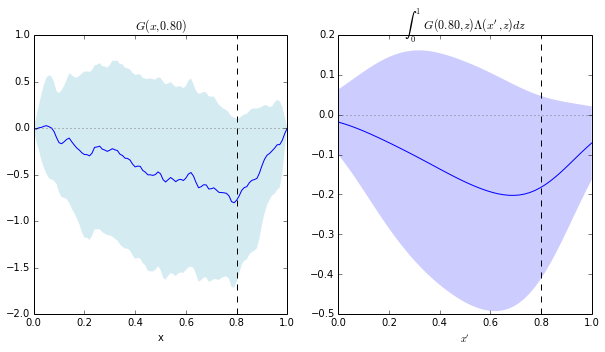

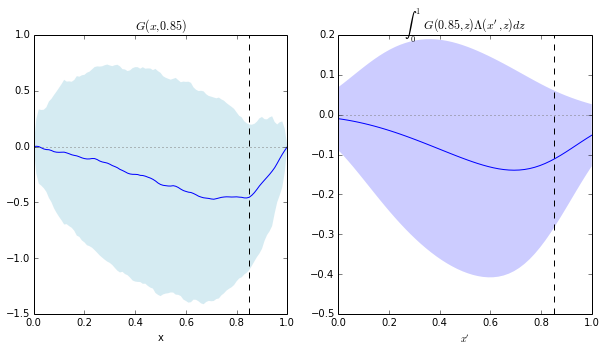

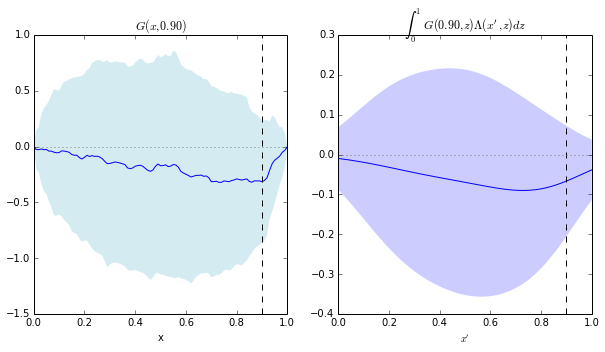

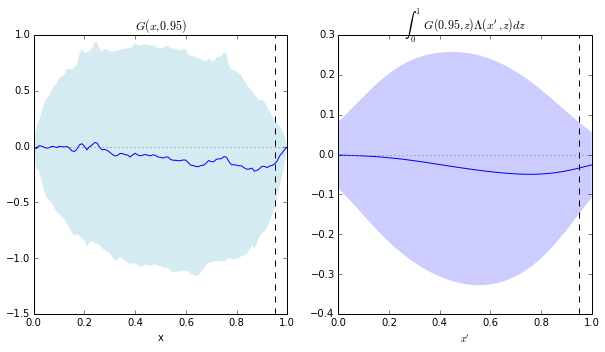

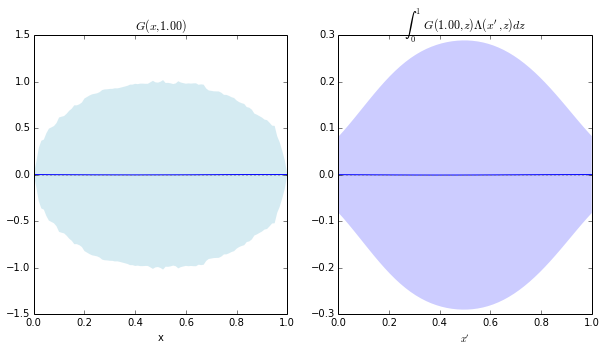

In [35]:
import sys
for x_prime in x_primes:
    plt.figure(figsize=(10,5))
    fns = results[x_prime]
    ak_samp = Ak(fns, dof_coordinates, lambda x,y: np.exp(-(x-y)**2 / (0.2**2)))
    #for x in np.linspace(0,1, 50):
    #    samp = ak_samp(x)
    #    plt.boxplot(samp, positions=[x], widths=(0.01))
    #    
    ys = []
    xs = np.linspace(0,1,50)
    stds = []
    for x in xs:
        #print np.abs(x-x_prime), np.mean(ak_samp(x))
        samp = ak_samp(x)
        ys.append(samp.mean())
        stds.append(samp.std())
        
    plt.subplot(121)
    plt.title('$G(x, {:.2f})$'.format(x_prime))
    plot_mcmc_results(fns)
    plt.axvline(x_prime, c='black', linestyle='--')
    plt.axhline(0, c='gray', linestyle='dotted')
    plt.xlim(0,1)
    plt.xlabel('x')
    plt.subplot(122)
    plt.title('$\int_0^1 G({:.2f}, z) \Lambda(x^\prime, z)dz $'.format(x_prime))
    plt.fill_between(np.array(xs), np.array(ys) - np.array(stds), np.array(ys) + np.array(stds), linewidth=0, alpha=0.2)
    plt.plot(xs, ys)
    plt.axvline(x_prime, c='black', linestyle='--')
    plt.axhline(0, c='gray', linestyle='dotted')
    plt.xlabel('$x^\prime$')
    plt.xlim(0,1)
    plt.show()
    plt.close()

So what's the problem here? It's that once again I don't have any way of linking the paths here. So we have a squiggly path representing $G(x, x_1)$ and a squiggly path representing $G(x, x_2)$ and there's no way to link them. So if I want to condition then I can't.

In [27]:
f = lambda x: np.sin(2*np.pi*x)

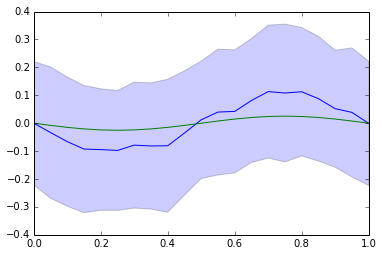

In [37]:
ys = np.zeros_like(x_primes)
stds = np.zeros_like(x_primes)
for i, x_prime in enumerate(x_primes):
    fns = results[x_prime]
    u_samp = u(fns, dof_coordinates, f)
    ys[i] = np.mean(u_samp)
    stds[i] = np.std(u_samp)
plt.plot(x_primes, ys)
plt.fill_between(x_primes, ys-stds, ys+stds, alpha=0.2)
plt.plot(x_primes, -np.sin(2*np.pi*x_primes) / (4*np.pi**2), c='green')